<a href="https://colab.research.google.com/github/juvana81/CODSOFT/blob/main/Sales_Prediction_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import warnings

plt.style.use('seaborn-v0_8')
sns.set_palette("colorblind")

Load Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

# Load the dataset
df = pd.read_csv('advertising.csv')

Sales Analysis

In [6]:

print("=" * 50)
print("ADVERTISING SALES ANALYSIS")
print("=" * 50)

# Display the first few rows of the dataset
print("\n1. DATASET PREVIEW:")
print(df.head())

# Dataset information
print("\n2. DATASET INFORMATION:")
print(f"- Number of records: {df.shape[0]}")
print(f"- Number of features: {df.shape[1] - 1}")  # excluding Sales
print(f"- Features available: {', '.join(df.columns[:-1])}")

# Check for missing values
missing_values = df.isnull().sum()
print("\n3. MISSING VALUES CHECK:")
if missing_values.sum() == 0:
    print("✓ No missing values found.")
else:
    print(missing_values)

# Summary statistics
print("\n4. SUMMARY STATISTICS:")
print(df.describe().round(2))

ADVERTISING SALES ANALYSIS

1. DATASET PREVIEW:
      TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3   12.0
3  151.5   41.3       58.5   16.5
4  180.8   10.8       58.4   17.9

2. DATASET INFORMATION:
- Number of records: 200
- Number of features: 3
- Features available: TV, Radio, Newspaper

3. MISSING VALUES CHECK:
✓ No missing values found.

4. SUMMARY STATISTICS:
           TV   Radio  Newspaper   Sales
count  200.00  200.00     200.00  200.00
mean   147.04   23.26      30.55   15.13
std     85.85   14.85      21.78    5.28
min      0.70    0.00       0.30    1.60
25%     74.38    9.98      12.75   11.00
50%    149.75   22.90      25.75   16.00
75%    218.82   36.52      45.10   19.05
max    296.40   49.60     114.00   27.00


visulatization


5. CREATING VISUALIZATIONS...


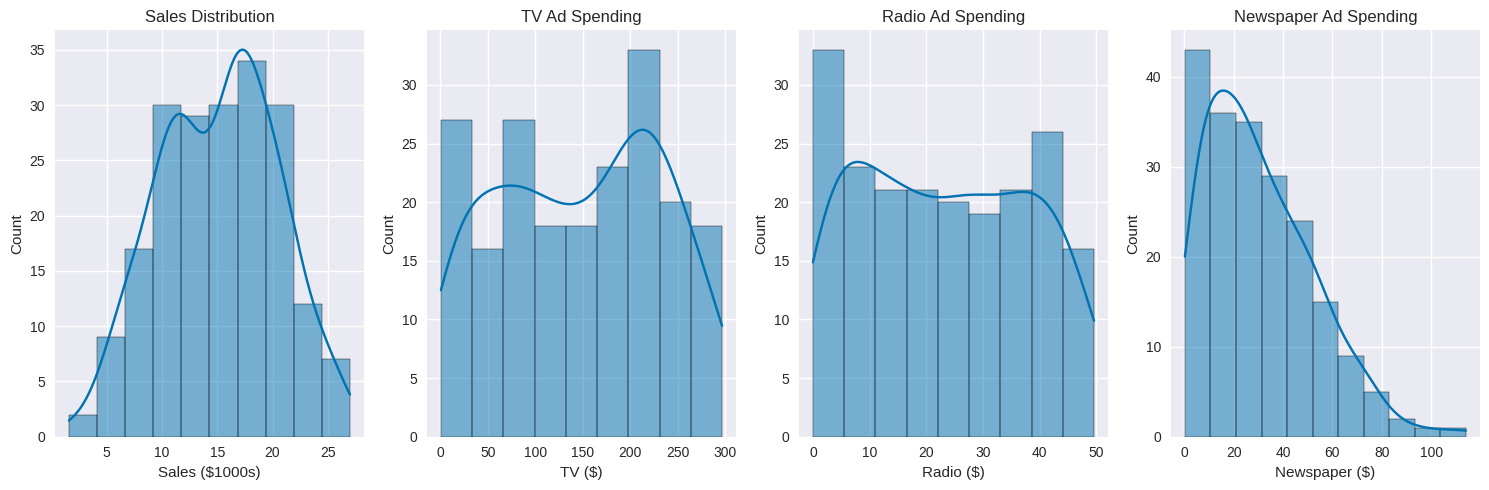

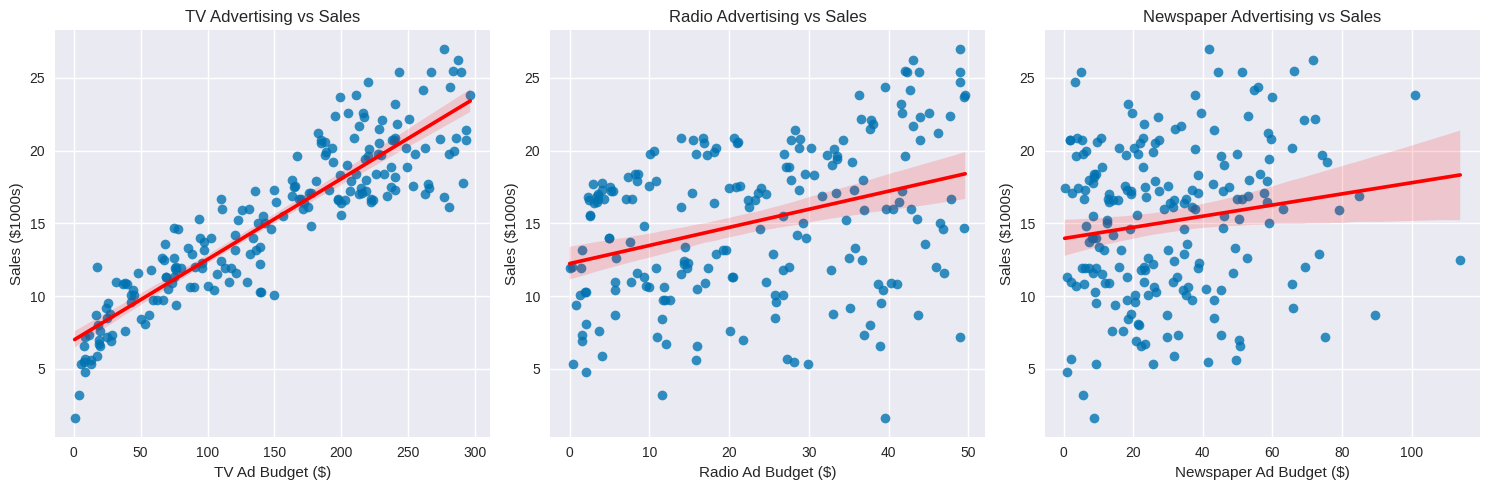

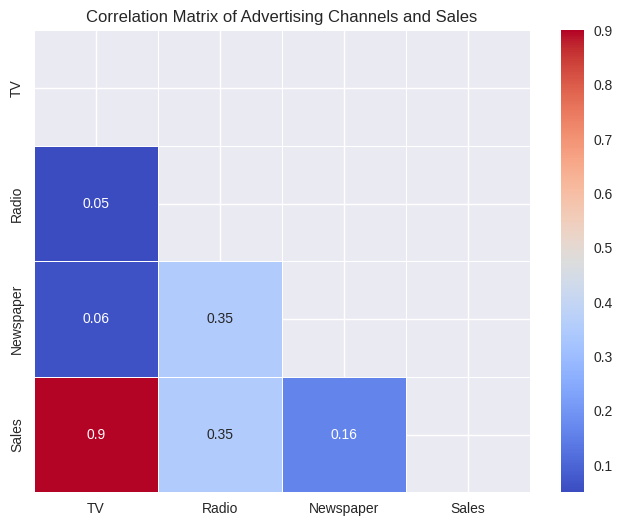


6. CORRELATION ANALYSIS:
Sales        1.00
TV           0.90
Radio        0.35
Newspaper    0.16
Name: Sales, dtype: float64


In [7]:
print("\n5. CREATING VISUALIZATIONS...")

# Create a figure for distribution plots
plt.figure(figsize=(15, 5))

# Distribution of the target variable (Sales)
plt.subplot(1, 4, 1)
sns.histplot(df['Sales'], kde=True)
plt.title('Sales Distribution')
plt.xlabel('Sales ($1000s)')

# Distribution of predictors
plt.subplot(1, 4, 2)
sns.histplot(df['TV'], kde=True)
plt.title('TV Ad Spending')
plt.xlabel('TV ($)')

plt.subplot(1, 4, 3)
sns.histplot(df['Radio'], kde=True)
plt.title('Radio Ad Spending')
plt.xlabel('Radio ($)')

plt.subplot(1, 4, 4)
sns.histplot(df['Newspaper'], kde=True)
plt.title('Newspaper Ad Spending')
plt.xlabel('Newspaper ($)')

plt.tight_layout()
plt.savefig('distributions.png')
plt.show()

# Create subplots for each feature vs Sales with regression line
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.regplot(x='TV', y='Sales', data=df, line_kws={"color": "red"})
plt.title('TV Advertising vs Sales')
plt.xlabel('TV Ad Budget ($)')
plt.ylabel('Sales ($1000s)')

plt.subplot(1, 3, 2)
sns.regplot(x='Radio', y='Sales', data=df, line_kws={"color": "red"})
plt.title('Radio Advertising vs Sales')
plt.xlabel('Radio Ad Budget ($)')
plt.ylabel('Sales ($1000s)')

plt.subplot(1, 3, 3)
sns.regplot(x='Newspaper', y='Sales', data=df, line_kws={"color": "red"})
plt.title('Newspaper Advertising vs Sales')
plt.xlabel('Newspaper Ad Budget ($)')
plt.ylabel('Sales ($1000s)')

plt.tight_layout()
plt.savefig('regression_plots.png')
plt.show()

# Correlation matrix with heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df.corr().round(2)
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)
plt.title('Correlation Matrix of Advertising Channels and Sales')
plt.savefig('correlation_matrix.png')
plt.show()

print("\n6. CORRELATION ANALYSIS:")
# Display correlations with Sales in descending order
correlations = correlation_matrix['Sales'].sort_values(ascending=False)
print(correlations)


Feature Engineering

In [8]:
print("\n7. FEATURE ENGINEERING:")

# Create a copy of the original dataframe
df_extended = df.copy()

# Add interaction terms
df_extended['TV_Radio'] = df['TV'] * df['Radio']
df_extended['TV_Newspaper'] = df['TV'] * df['Newspaper']
df_extended['Radio_Newspaper'] = df['Radio'] * df['Newspaper']

# Add polynomial terms (squared terms)
df_extended['TV_Squared'] = df['TV'] ** 2
df_extended['Radio_Squared'] = df['Radio'] ** 2
df_extended['Newspaper_Squared'] = df['Newspaper'] ** 2

print("Added new features:")
for col in df_extended.columns:
    if col not in df.columns:
        print(f"- {col}")


7. FEATURE ENGINEERING:
Added new features:
- TV_Radio
- TV_Newspaper
- Radio_Newspaper
- TV_Squared
- Radio_Squared
- Newspaper_Squared


Model Building and Evaluation

In [9]:
print("\n8. MODEL BUILDING AND EVALUATION:")

# Define feature sets for comparison
models = {
    "Basic Model (TV, Radio, Newspaper)": df[['TV', 'Radio', 'Newspaper']],
    "Interaction Model": df_extended[['TV', 'Radio', 'Newspaper', 'TV_Radio',
                                     'TV_Newspaper', 'Radio_Newspaper']],
    "Full Model": df_extended.drop('Sales', axis=1)
}

results = {}

for model_name, features in models.items():
    # Split data
    X = features
    y = df['Sales']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Cross-validation score
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

    # Store results
    results[model_name] = {
        'model': model,
        'features': X.columns.tolist(),
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred
    }

    # Display results
    print(f"\n{model_name}:")
    print(f"- Mean Squared Error: {mse:.4f}")
    print(f"- Root Mean Squared Error: {rmse:.4f}")
    print(f"- R² Score (Test Set): {r2:.4f}")
    print(f"- 5-Fold Cross-Validation R² Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    # Display coefficients
    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_
    }).sort_values('Coefficient', ascending=False)

    print("\nFeature Coefficients:")
    print(coef_df)
    print(f"Intercept: {model.intercept_:.4f}")

# Select the best model based on cross-validation score
best_model_name = max(results, key=lambda x: results[x]['cv_r2_mean'])
best_model = results[best_model_name]

print(f"\n9. BEST MODEL: {best_model_name}")
print(f"- R² Score: {best_model['r2']:.4f}")
print(f"- Cross-Validation R² Score: {best_model['cv_r2_mean']:.4f}")

# ----------------------


8. MODEL BUILDING AND EVALUATION:

Basic Model (TV, Radio, Newspaper):
- Mean Squared Error: 2.5416
- Root Mean Squared Error: 1.5942
- R² Score (Test Set): 0.9091
- 5-Fold Cross-Validation R² Score: 0.8954 (±0.0314)

Feature Coefficients:
     Feature  Coefficient
1      Radio     0.102707
0         TV     0.053589
2  Newspaper     0.007932
Intercept: 4.7438

Interaction Model:
- Mean Squared Error: 2.0598
- Root Mean Squared Error: 1.4352
- R² Score (Test Set): 0.9264
- 5-Fold Cross-Validation R² Score: 0.9005 (±0.0245)

Feature Coefficients:
           Feature  Coefficient
0               TV     0.045716
1            Radio     0.026690
2        Newspaper     0.006883
3         TV_Radio     0.000421
5  Radio_Newspaper     0.000384
4     TV_Newspaper    -0.000064
Intercept: 6.2071

Full Model:
- Mean Squared Error: 1.5025
- Root Mean Squared Error: 1.2258
- R² Score (Test Set): 0.9463
- 5-Fold Cross-Validation R² Score: 0.9254 (±0.0172)

Feature Coefficients:
             Feature  Co

Feature imortance analysis


10. FEATURE IMPORTANCE ANALYSIS:
             Feature  Coefficient  Abs_Coefficient  Ranking
0                 TV     0.078828         0.078828        2
1              Radio    -0.054706         0.054706        1
7      Radio_Squared     0.001822         0.001822        3
2          Newspaper     0.001103         0.001103        5
3           TV_Radio     0.000422         0.000422        4
5    Radio_Newspaper     0.000167         0.000167        6
8  Newspaper_Squared     0.000164         0.000164        7
6         TV_Squared    -0.000112         0.000112        8
4       TV_Newspaper    -0.000067         0.000067        9


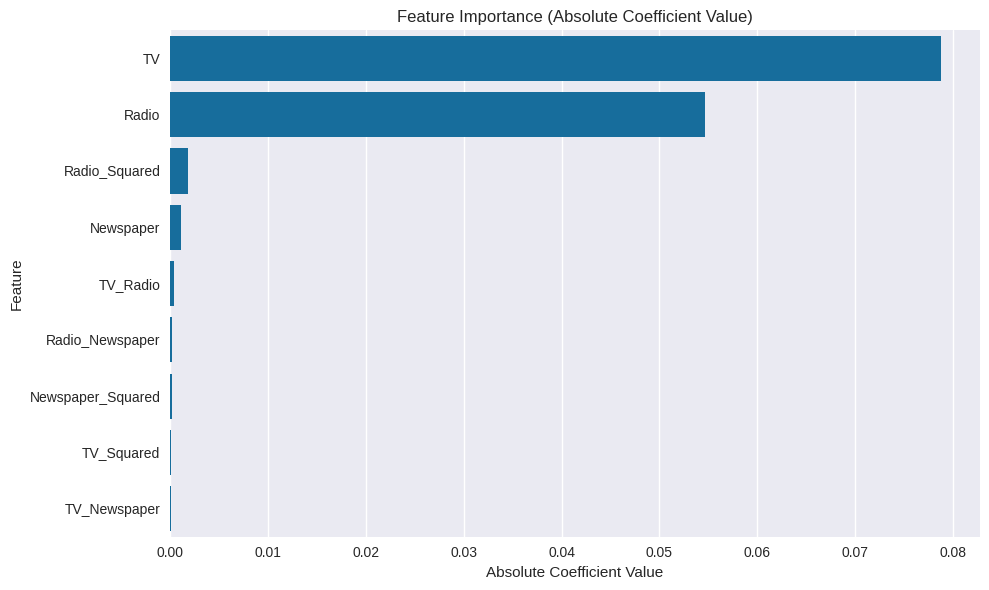

In [10]:
print("\n10. FEATURE IMPORTANCE ANALYSIS:")

# Get the best model's features and coefficients
X_best = models[best_model_name]
model_best = best_model['model']

# Perform feature ranking using Recursive Feature Elimination
rfe = RFE(model_best, n_features_to_select=1)
rfe.fit(X_best, df['Sales'])

# Create and display feature ranking
feature_ranking = pd.DataFrame({
    'Feature': X_best.columns,
    'Coefficient': model_best.coef_,
    'Abs_Coefficient': abs(model_best.coef_),
    'Ranking': rfe.ranking_
})
feature_ranking = feature_ranking.sort_values('Abs_Coefficient', ascending=False)
print(feature_ranking)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_ranking)
plt.title('Feature Importance (Absolute Coefficient Value)')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

Model Visualization


11. MODEL VISUALIZATION:


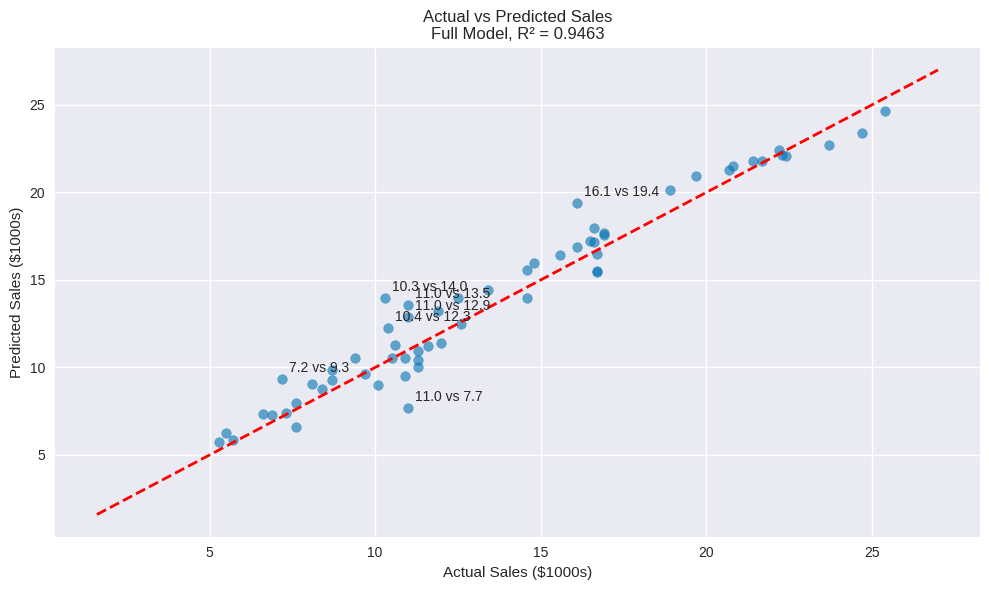

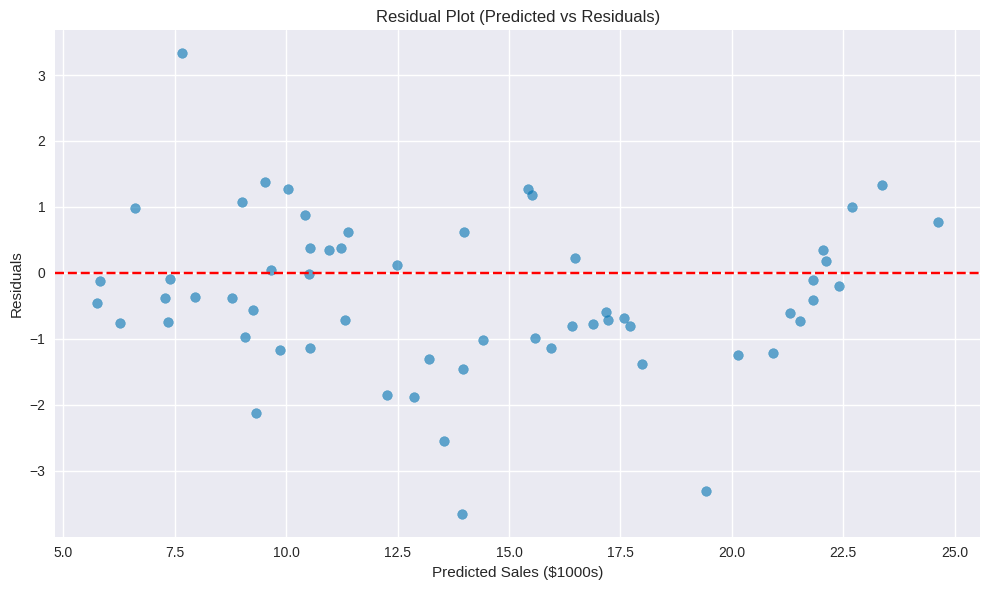

In [11]:
print("\n11. MODEL VISUALIZATION:")

# Create a plot for actual vs predicted values for the best model
plt.figure(figsize=(10, 6))
plt.scatter(best_model['y_test'], best_model['y_pred'], alpha=0.6)
plt.plot([df['Sales'].min(), df['Sales'].max()],
         [df['Sales'].min(), df['Sales'].max()],
         'r--', lw=2)
plt.xlabel('Actual Sales ($1000s)')
plt.ylabel('Predicted Sales ($1000s)')
plt.title(f'Actual vs Predicted Sales\n{best_model_name}, R² = {best_model["r2"]:.4f}')

# Add annotations for outliers
residuals = best_model['y_test'] - best_model['y_pred']
std_residuals = np.std(residuals)
for i, (actual, pred, res) in enumerate(zip(best_model['y_test'], best_model['y_pred'], residuals)):
    if abs(res) > 1.5 * std_residuals:
        plt.annotate(f"{actual:.1f} vs {pred:.1f}",
                     (actual, pred),
                     xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(best_model['y_pred'], residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Sales ($1000s)')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Residuals)')
plt.tight_layout()
plt.savefig('residual_plot.png')
plt.show()


Sales prediction Fuction

In [13]:
print("\n12. SALES PREDICTION FUNCTION:")

def predict_sales(tv=0, radio=0, newspaper=0, model_name=best_model_name):

    if model_name not in results:
        print(f"Error: Model '{model_name}' not found.")
        return None

    model = results[model_name]['model']
    features = results[model_name]['features']

    # Create a dataframe with input values
    input_data = pd.DataFrame([[tv, radio, newspaper]], columns=['TV', 'Radio', 'Newspaper'])

    # Add interaction and polynomial terms if needed
    if 'TV_Radio' in features:
        input_data['TV_Radio'] = input_data['TV'] * input_data['Radio']
    if 'TV_Newspaper' in features:
        input_data['TV_Newspaper'] = input_data['TV'] * input_data['Newspaper']
    if 'Radio_Newspaper' in features:
        input_data['Radio_Newspaper'] = input_data['Radio'] * input_data['Newspaper']
    if 'TV_Squared' in features:
        input_data['TV_Squared'] = input_data['TV'] ** 2
    if 'Radio_Squared' in features:
        input_data['Radio_Squared'] = input_data['Radio'] ** 2
    if 'Newspaper_Squared' in features:
        input_data['Newspaper_Squared'] = input_data['Newspaper'] ** 2

    # Select only the features used by the model
    input_features = input_data[features]

    # Make prediction
    prediction = model.predict(input_features)[0]

    return prediction

# Example prediction
tv = 200
radio = 40
newspaper = 60

predicted_sales = predict_sales(tv, radio, newspaper)
print(f"Predicted sales for TV=${tv}, Radio=${radio}, Newspaper=${newspaper}: ${predicted_sales:.2f}k")




12. SALES PREDICTION FUNCTION:
Predicted sales for TV=$200, Radio=$40, Newspaper=$60: $20.86k


Budget Optimization

In [14]:
print("\n13. BUDGET OPTIMIZATION:")

def optimize_budget(total_budget=300, model_name=best_model_name):
    """
    Find optimal allocation of advertising budget

    Parameters:
    -----------
    total_budget : float
        Total advertising budget in dollars
    model_name : str
        Model to use for prediction

    Returns:
    --------
    dict
        Optimal allocation and predicted sales
    """
    best_sales = 0
    best_allocation = None

    # Create a grid of possible allocations
    step = total_budget / 20  # 5% steps

    for tv_pct in range(0, 21):  # 0% to 100% in 5% steps
        tv_budget = tv_pct * step
        for radio_pct in range(0, 21 - tv_pct):  # remaining % in 5% steps
            radio_budget = radio_pct * step
            newspaper_budget = total_budget - tv_budget - radio_budget

            # Skip invalid allocations
            if newspaper_budget < 0:
                continue

            # Predict sales
            sales = predict_sales(tv_budget, radio_budget, newspaper_budget, model_name)

            if sales > best_sales:
                best_sales = sales
                best_allocation = {
                    'TV': tv_budget,
                    'Radio': radio_budget,
                    'Newspaper': newspaper_budget,
                    'Predicted_Sales': sales
                }

    return best_allocation

# Optimize for different budget levels
budgets = [100, 200, 300, 500, 1000]
optimization_results = {}

for budget in budgets:
    optimization_results[budget] = optimize_budget(budget)
    allocation = optimization_results[budget]
    print(f"\nOptimal allocation for ${budget} budget:")
    print(f"- TV: ${allocation['TV']:.2f} ({allocation['TV']/budget*100:.1f}%)")
    print(f"- Radio: ${allocation['Radio']:.2f} ({allocation['Radio']/budget*100:.1f}%)")
    print(f"- Newspaper: ${allocation['Newspaper']:.2f} ({allocation['Newspaper']/budget*100:.1f}%)")
    print(f"- Predicted Sales: ${allocation['Predicted_Sales']:.2f}k")



13. BUDGET OPTIMIZATION:

Optimal allocation for $100 budget:
- TV: $0.00 (0.0%)
- Radio: $100.00 (100.0%)
- Newspaper: $0.00 (0.0%)
- Predicted Sales: $17.95k

Optimal allocation for $200 budget:
- TV: $0.00 (0.0%)
- Radio: $200.00 (100.0%)
- Newspaper: $0.00 (0.0%)
- Predicted Sales: $67.14k

Optimal allocation for $300 budget:
- TV: $0.00 (0.0%)
- Radio: $300.00 (100.0%)
- Newspaper: $0.00 (0.0%)
- Predicted Sales: $152.75k

Optimal allocation for $500 budget:
- TV: $0.00 (0.0%)
- Radio: $500.00 (100.0%)
- Newspaper: $0.00 (0.0%)
- Predicted Sales: $433.29k

Optimal allocation for $1000 budget:
- TV: $0.00 (0.0%)
- Radio: $1000.00 (100.0%)
- Newspaper: $0.00 (0.0%)
- Predicted Sales: $1772.23k


Conclusion

In [15]:
print("\n14. CONCLUSION:")
print(f"- Best Model: {best_model_name}")
print(f"- Model Accuracy (R²): {best_model['r2']:.4f}")
print(f"- Most important advertising channel: {feature_ranking.iloc[0]['Feature']}")
print(f"- For a budget of $300, optimal allocation is approximately:")
print(f"  * TV: ${optimization_results[300]['TV']:.2f}")
print(f"  * Radio: ${optimization_results[300]['Radio']:.2f}")



14. CONCLUSION:
- Best Model: Full Model
- Model Accuracy (R²): 0.9463
- Most important advertising channel: TV
- For a budget of $300, optimal allocation is approximately:
  * TV: $0.00
  * Radio: $300.00
